<a href="https://colab.research.google.com/github/israelklink/Financas_Descentralizadas_Python/blob/main/Simulacao_Circle_USDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   O gráfico de preço mostrará flutuações em torno de 1 com desvios em períodos críticos.

*   A barra de risco marcará períodos em que Q_USDC > R_USD, ou seja, o token estaria emitido sem respaldo.

*   O print() final indicará o erro da paridade e o número total de períodos com risco sistêmico.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

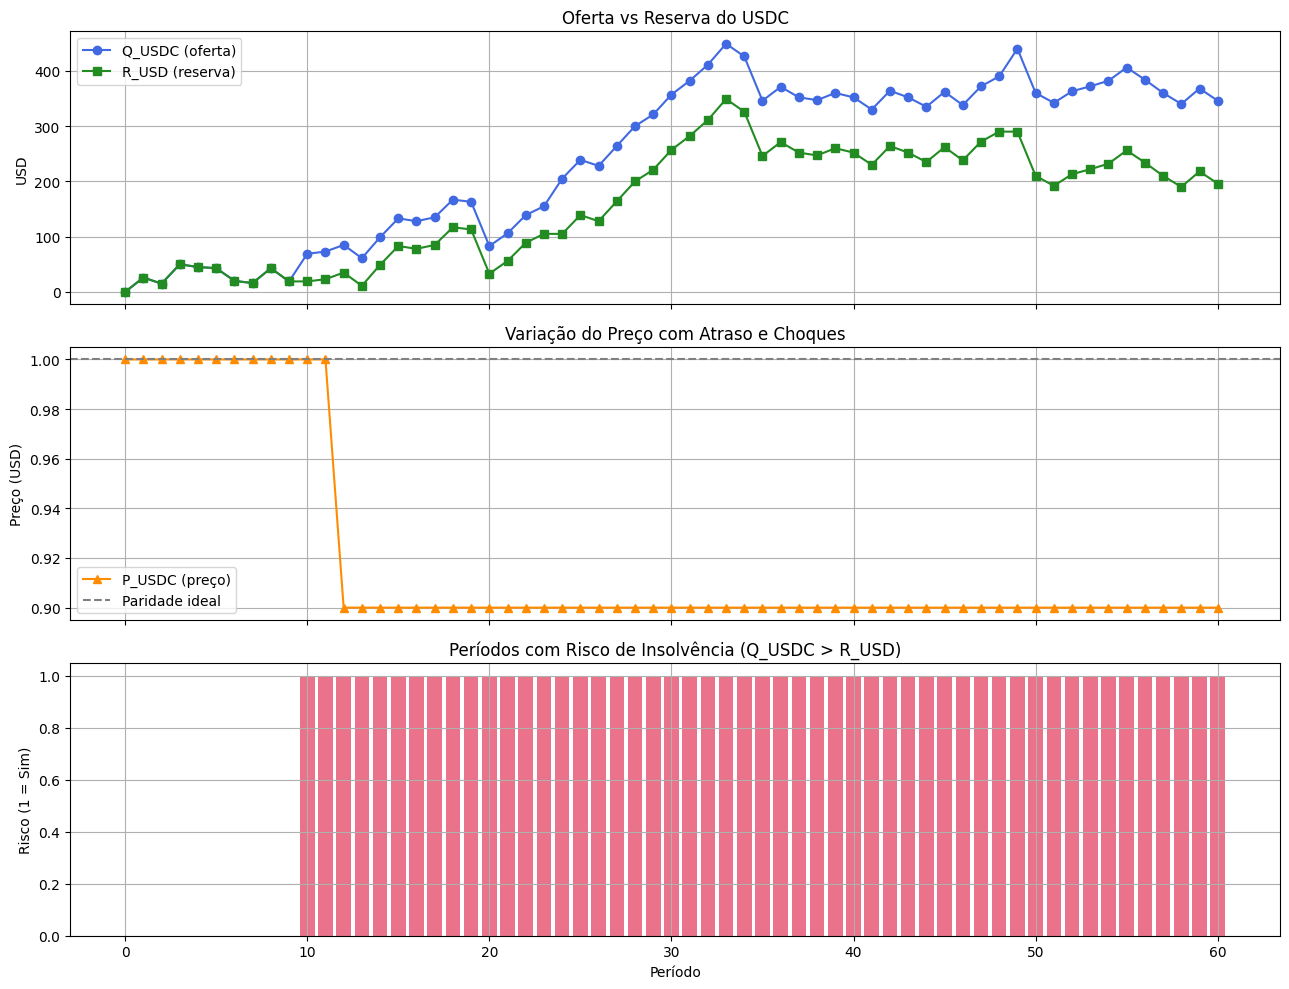

Erro quadrático médio da paridade: 0.008167
Número de períodos com risco de insolvência: 51


In [11]:
# Parâmetros
np.random.seed(42)
n_periods = 60
lag = 2
shock_periods = [20, 35, 50]        # Resgates em massa
fraude_periods = [10, 24, 49]       # Emissão sem lastro

# Inicialização
Q_USDC = [0]
R_USD = [0]
P_USDC = [1.0]
riscos = []
desvios = []

# Função de ajuste de preço com arbitragem e atraso
def ajustar_preco(precos, reservas, ofertas, t):
    if t < lag:
        return 1.0
    reserva = reservas[t - lag]
    oferta = ofertas[t - lag]
    delta = (reserva - oferta) / max(reserva, oferta, 1)
    return max(0.90, min(1.10, precos[t - 1] + 0.4 * delta))

# Simulação
for t in range(1, n_periods + 1):
    if t in shock_periods:
        delta = -80
    elif t in fraude_periods:
        delta = 50  # Emissão sem depósito
    else:
        delta = np.random.randint(-25, 40)

    q_novo = max(Q_USDC[-1] + delta, 0)

    # Em períodos fraudulentos, reservas não aumentam
    if t in fraude_periods:
        r_novo = R_USD[-1]
    else:
        r_novo = max(R_USD[-1] + delta, 0)

    Q_USDC.append(q_novo)
    R_USD.append(r_novo)

    # Preço com lag e arbitragem
    p_novo = ajustar_preco(P_USDC, R_USD, Q_USDC, t)
    P_USDC.append(p_novo)

    # Risco de insolvência
    risco = 1 if q_novo > r_novo else 0
    riscos.append(risco)

    # Desvio quadrático da paridade
    desvios.append((p_novo - 1.0) ** 2)

# Métricas
erro_quadratico_medio = np.mean(desvios)
n_riscos = sum(riscos)

# Visualização
fig, axs = plt.subplots(3, 1, figsize=(13, 10), sharex=True)

# Gráfico 1: Emissão vs Reserva
axs[0].plot(Q_USDC, label='Q_USDC (oferta)', marker='o', color='royalblue')
axs[0].plot(R_USD, label='R_USD (reserva)', marker='s', color='forestgreen')
axs[0].set_ylabel('USD')
axs[0].set_title('Oferta vs Reserva do USDC')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2: Preço
axs[1].plot(P_USDC, label='P_USDC (preço)', color='darkorange', marker='^')
axs[1].axhline(1.0, linestyle='--', color='gray', label='Paridade ideal')
axs[1].set_ylabel('Preço (USD)')
axs[1].set_title('Variação do Preço com Atraso e Choques')
axs[1].legend()
axs[1].grid(True)

# Gráfico 3: Risco
axs[2].bar(range(1, n_periods + 1), riscos, color='crimson', alpha=0.6)
axs[2].set_ylabel('Risco (1 = Sim)')
axs[2].set_xlabel('Período')
axs[2].set_title('Períodos com Risco de Insolvência (Q_USDC > R_USD)')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Relatório
print(f"Erro quadrático médio da paridade: {erro_quadratico_medio:.6f}")
print(f"Número de períodos com risco de insolvência: {n_riscos}")
